<a href="https://colab.research.google.com/github/warlords94/personal-coding/blob/main/Sliency_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
%tensorflow_version 2.x

import tensorflow as tf
import tensorflow_hub as hub
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [9]:
model = tf.keras.Sequential([
                            hub.KerasLayer('https://tfhub.dev/google/tf2-preview/inception_v3/classification/4'),
                            tf.keras.layers.Activation('softmax')
])

model.build([None, 300,300,3])

In [10]:
!wget -O image.jpg https://cdn.pixabay.com/photo/2018/02/27/14/11/the-pacific-ocean-3185553_960_720.jpg

# If you want to try the cat, uncomment this line
# !wget -O image.jpg https://cdn.pixabay.com/photo/2018/02/27/14/11/the-pacific-ocean-3185553_960_720.jpg

--2022-06-19 05:15:20--  https://cdn.pixabay.com/photo/2018/02/27/14/11/the-pacific-ocean-3185553_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.37.244, 172.64.150.12, 2606:4700:4400::ac40:960c, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.37.244|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 115705 (113K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>] 112.99K  --.-KB/s    in 0.003s  

2022-06-19 05:15:21 (40.0 MB/s) - ‘image.jpg’ saved [115705/115705]



In [13]:
img = cv2.imread('image.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img , (300,300))/255.0
image = np.expand_dims(img , axis =0)

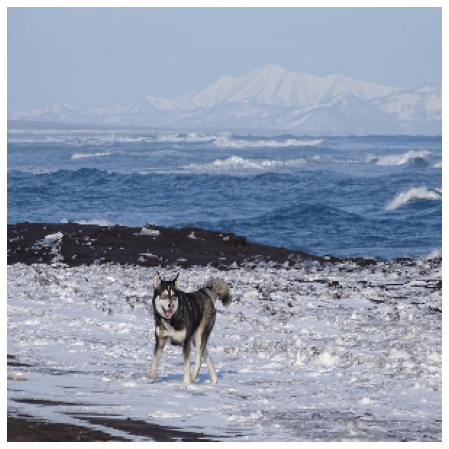

In [14]:
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

In [27]:
class_index = 251
num_classes = 1001
expected_output = tf.one_hot([class_index]*image.shape[0],num_classes)
with tf.GradientTape() as tape:
  inputs = tf.cast (image , tf.float32)
  tape.watch(inputs)
  predictions = model(inputs)
  loss = tf.keras.losses.categorical_crossentropy(
        expected_output, predictions
    )

gradients = tape.gradient(loss, inputs) 

In [29]:
grayscale_tensor =tf.reduce_sum(tf.abs(gradients), axis =-1)
normalized_tensor = tf.cast(
    255 *(grayscale_tensor - tf.reduce_min(gradients))
    /(tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),
    tf.uint8,
)

normalized_tensor = tf.squeeze(normalized_tensor)

In [30]:
# max and min value in the grayscale tensor
print(np.max(grayscale_tensor[0]))
print(np.min(grayscale_tensor[0]))
print()

# coordinates of the first pixel where the max and min values are located
max_pixel = np.unravel_index(np.argmax(grayscale_tensor[0]), grayscale_tensor[0].shape)
min_pixel = np.unravel_index(np.argmin(grayscale_tensor[0]), grayscale_tensor[0].shape)
print(max_pixel)
print(min_pixel)
print()

# these coordinates should have the max (255) and min (0) value in the normalized tensor
print(normalized_tensor[max_pixel])
print(normalized_tensor[min_pixel])

0.9235996
0.0

(191, 143)
(0, 299)

tf.Tensor(116, shape=(), dtype=uint8)
tf.Tensor(117, shape=(), dtype=uint8)


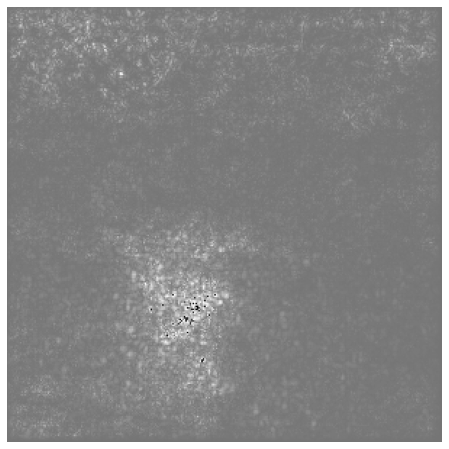

In [31]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(normalized_tensor, cmap='gray')
plt.show()

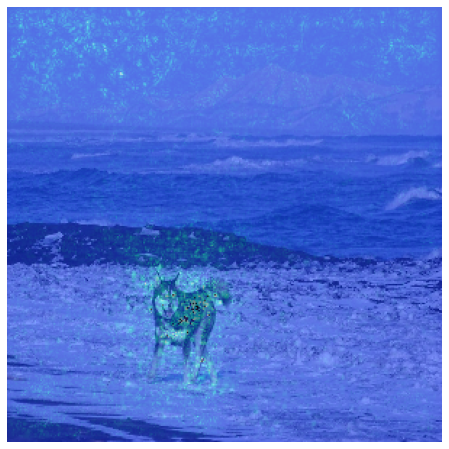

In [32]:
gradient_color = cv2.applyColorMap(normalized_tensor.numpy(), cv2.COLORMAP_HOT)
gradient_color = gradient_color / 255.0
super_imposed = cv2.addWeighted(img, 0.5, gradient_color, 0.5, 0.0)

plt.figure(figsize=(8, 8))
plt.imshow(super_imposed)
plt.axis('off')
plt.show()